In [374]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.integrate import odeint
import pandas as pd

## Define initial model parameters (at time 0)

In [511]:
# Define General Parameters
Xo = 0.01 # g/L
Yxs = 0.5 # g/g
mu_max = 0.44 # 1/h
Ks = 0.045 # Monod constant g/L
So = 5 # g/L
S_feed = 100 # g/L
V = 16000 # L
ms = 0.16 # g S / g X / h
qo2 = 0.256 # Oxygen uptake rate (gO2/gDCW/hr)
S_floor = 0.05 # g/L
Yos = 6 * 32 / 180 # grams O2 / g glucose

# Define Fed-Batch Parameters
Cx = 2
Cs = 1
phi = 1 # 0.85
alpha = phi / Cx

# Model Lag Phase
t_lag = 2 # hr

## Model the batch phase fermentation until S=S_floor g/L

In [525]:
# Model Batch Phase, solving for time to get to 0.05 g/L substrate
def dS_batchdt(t_final):
    def dX_batchdt(vec, t):
        X, S = vec
        mu_g = mu_max * S / (Ks + S)
        return np.array([X * mu_g, - (X * mu_g / Yxs) - ms * X])

    t = np.linspace(0, t_final[0], 1000)
    vec0 = [Xo, So]
    vec = odeint(dX_batchdt, vec0, t)
    return vec[-1, 1] - S_floor

t_final = fsolve(dS_batchdt, 10)[0]

def dX_batchdt(vec, t):
    X, S = vec
    mu_g = mu_max * S / (Ks + S)
    return np.array([X * mu_g, - (X * mu_g / Yxs) - ms * X])


t = np.linspace(0, t_final, 1000)
vec0 = [Xo, So]
vec = odeint(dX_batchdt, vec0, t)

batch_t_vals = t + 2
batch_X_vals = vec[:, 0]
batch_S_vals = vec[:, 1]

t_batch = t_final + 2
S_batch_final = vec[-1, 1]
X_batch_final = vec[-1, 0]
# print(t_final)
# print(batch_X_vals[-10:])
# print(batch_t_vals[-1])
# print(t_batch)

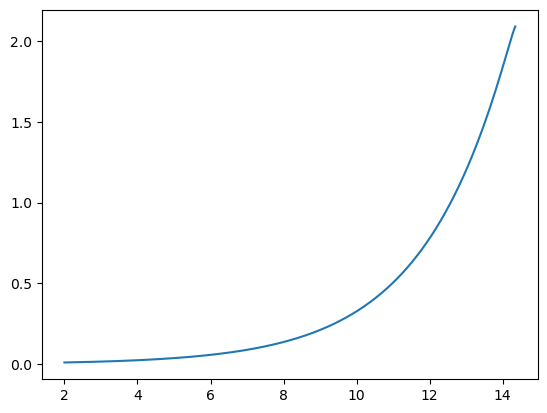

In [526]:
plt.plot(batch_t_vals, batch_X_vals)

## Model fed-batch fermentation holding S at S_floor g/L until OUR=OTR

In [527]:
# Model Fed-Batch until OUR = OTR for growth rate at 0.05
S_f1 = S_floor # g/L
Xo_fb1 = X_batch_final
OTR = 6.42 # Oxygen transfer rate (g/m^3/h)

def dOURdt_fb1(t_final):
    def ODE_fb1(vecs, t):
        S = S_f1
        X = vecs[0]

        mu_g = mu_max * S / (Ks + S)
        F = V / (S_feed + alpha * Cs * S - (1 + alpha) * S) * (ms * X + mu_g * X / Yxs)
        dXdt = F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X

        return np.array([dXdt])

    t = np.linspace(0, t_final[0], 1000)
    vec0 = [Xo_fb1]
    vec = odeint(ODE_fb1, vec0, t)

    mu_g = mu_max * S_f1 / (Ks + S_f1)
    OUR = qo2 * mu_g / mu_max * vec[-1, 0] + ms * vec[-1, 0] * Yos

    return OUR - OTR
sol = fsolve(dOURdt_fb1, 20)
t_fb1 = sol[0]

def ODE_fb1(vecs, t):
    S = S_f1
    X = vecs[0]

    mu_g = mu_max * S / (Ks + S)
    F = V / (S_feed + alpha * Cs * S - (1 + alpha) * S) * (ms * X + mu_g * X / Yxs)
    dXdt = F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X

    return np.array([dXdt])

t = np.linspace(0, t_fb1, 1000)
vec0 = [Xo_fb1]
vec = odeint(ODE_fb1, vec0, t)

fb1_t_vals = t + t_batch
fb1_X_vals = vec[:, 0]
fb1_S_vals = S_floor * np.ones(len(t))

t_fb1 = batch_t_vals[-1] + t_fb1

X_fb1_final = vec[-1, 0]

print(fb1_t_vals[0])


14.343119189874471


## Model Fed-Batch after OUR = OTR for growth rate at variable S until S=0

In [528]:
# Model Fed-Batch while OUR = OTR until S=0
S_f1 = S_floor # g/L
Xo_fb2 = X_fb1_final
OTR = 6.42 # Oxygen transfer rate (g/m^3/h)
t_final = 15 # hr

# Model the fed-batch until S = 0
def dXSdt(vec, dt):
    X, S_fb2 = vec

    def OUR(S):
        mu_g = mu_max * S / (Ks + S)
        F = ((S_fb2 - S) + ms * X + mu_g * X / Yxs) * V / (S_feed + alpha * Cs * S - (1 + alpha) * S)
        dXdt = (F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X) * dt
        return qo2 * mu_g / mu_max * (X + dXdt) + ms * (X + dXdt) * Yos - OTR

    S = fsolve(OUR, S_floor)[0]
    mu_g = mu_max * S / (Ks + S)

    F = ((S_fb2 - S) + ms * X + mu_g * X / Yxs) * V / (S_feed + alpha * Cs * S - (1 + alpha) * S)
    dXdt = (F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X) * dt
    
    return np.array([X + dXdt, S])

t = np.linspace(0, t_final, 1000)
vec = np.array([dXSdt([Xo_fb2, S_f1], t[0])])
dt = t[1] - t[0]
for time in t[1:]:
    ret = dXSdt([vec[-1, 0], vec[-1, 1]], dt)
    vec = np.append(vec, ret.reshape((1, 2)), axis=0)
    
# vec0 = [Xo_fb2, S_f1]
# vec = odeint(dXSdt, vec0, t)

fb2_t_vals = t + t_fb1
fb2_X_vals = vec[:, 0]
fb2_S_vals = vec[:, 1]

t_fb2 = fb1_t_vals[-1] + t_final

X_fb2_final = vec[-1, 0]

## Putting it all together (plotting)

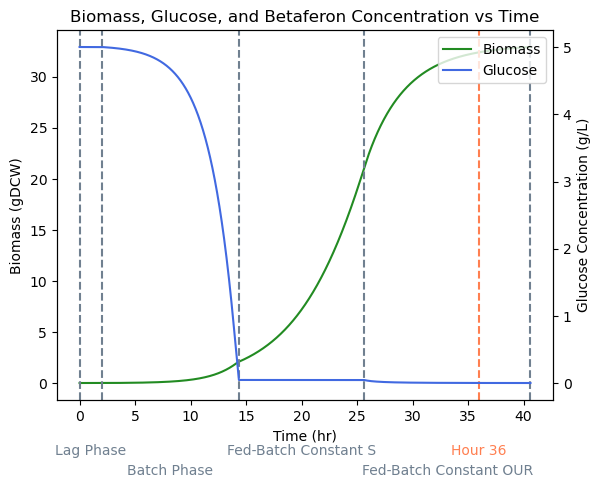

In [529]:
# Lag phase values
t = np.array([0, 2]) 
X = np.array([Xo, Xo]) 
S = np.array([So, So]) 

# Concatenate all values
t_vals = np.concatenate([t, batch_t_vals, fb1_t_vals, fb2_t_vals])
X_vals = np.concatenate([X, batch_X_vals, fb1_X_vals, fb2_X_vals])
S_vals = np.concatenate([S, batch_S_vals, fb1_S_vals, fb2_S_vals])

# t_vals = np.concatenate([t, batch_t_vals, fb1_t_vals])
# X_vals = np.concatenate([X, batch_X_vals, fb1_X_vals])
# S_vals = np.concatenate([S, batch_S_vals, fb1_S_vals])

# Plot
data = pd.DataFrame({'Time (hr)': t_vals, 'Biomass (gDCW)': X_vals, "Glucose Concentration (g/L)": S_vals})

# Set up the figure and axes
fig, ax1 = plt.subplots()

# Plot biomass on the first y-axis
ax1.plot(data['Time (hr)'], data['Biomass (gDCW)'], color='forestgreen', label='Biomass')
ax1.set_xlabel('Time (hr)')
ax1.set_ylabel('Biomass (gDCW)')
ax2 = ax1.twinx()

# Plot glucose concentration on the second y-axis
ax2.plot([], [], color="forestgreen", label="Biomass")
ax2.plot(data['Time (hr)'], data['Glucose Concentration (g/L)'], color='royalblue', label='Glucose')
ax2.set_ylabel('Glucose Concentration (g/L)')

# Add legend
ax2.legend(loc='upper right')

# Add lines
ax1.axvline(x=0, color='slategray', linestyle='--')
ax1.axvline(x=2, color='slategray', linestyle='--')
ax1.axvline(x=t_batch, color='slategray', linestyle='--')
ax1.axvline(x=t_fb1, color='slategray', linestyle='--')
ax1.axvline(x=t_fb2, color='slategray', linestyle='--')
ax1.axvline(x=36, color='coral', linestyle='--')
ax1.text(1, -7, 'Lag Phase', color='slategray', ha='center')
ax1.text((t_batch - 2) / 2 + 2, -9, 'Batch Phase', color='slategray', ha='center')
ax1.text((t_fb1 - t_batch) / 2 + t_batch, -7, 'Fed-Batch Constant S', color='slategray', ha='center')
ax1.text((t_fb2 - t_fb1) / 2 + t_fb1, -9, 'Fed-Batch Constant OUR', color='slategray', ha='center')
ax1.text(36, -7, 'Hour 36', color='coral', ha='center')

# Set the title
ax1.set_title('Biomass, Glucose, and Betaferon Concentration vs Time')

# Show the plot
plt.show()


## Get the final biomass concentration after 36hr

In [456]:
print(f"The biomass concentration at hour 36 is: {X_vals[np.argmin(np.abs(t_vals - 36))]}")
print(f"The glucose concentration at hour 36 is: {S_vals[np.argmin(np.abs(t_vals - 36))]}")

The biomass concentration at hour 36 is: 32.47278248157771
The glucose concentration at hour 36 is: 0.005313886259840132


In [467]:
print(t_batch, t_fb1, t_fb2)

15.822112339648546 26.199168184529412 41.19916818452941


## Combine everything to find most effective S_floor

Text(0, 0.5, 'Biomass concentration at hour 36 (gDCW)')

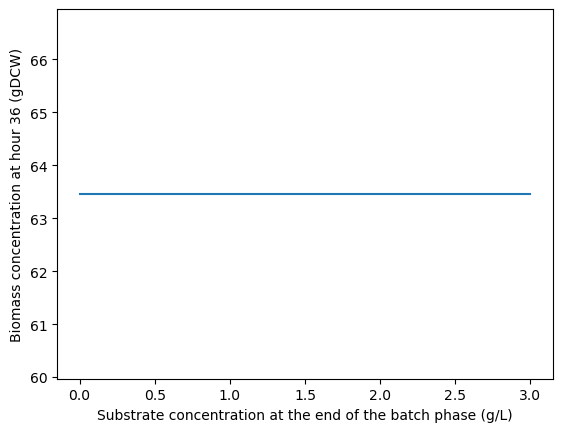

In [398]:
s_floors = np.linspace(0.0001, 3, 200)

def everything(S_floor):
    # Define General Parameters
    Xo = 0.01 # g/L
    Yxs = 0.5 # g/g
    mu_max = 0.44 # 1/h
    Ks = 0.045 # Monod constant g/L
    So = 5 # g/L
    S_feed = 100 # g/L
    V = 16000 # L
    ms = 0.03 # g S / g X / h
    qo2 = 0.256 # Oxygen uptake rate (gO2/gDCW/hr)
    S_floor = 0.05 # g/L
    Yos = 6 * 32 / 180 # grams O2 / g glucose

    # Define Fed-Batch Parameters
    Cx = 2
    Cs = 1
    phi = 1 # 0.85
    alpha = phi / Cx

    # Model Lag Phase
    t_lag = 2 # hr

    # Model Batch Phase, solving for time to get to 0.05 g/L substrate
    def dS_batchdt(t_final):
        def dX_batchdt(vec, t):
            X, S = vec
            mu_g = mu_max * S / (Ks + S)
            return np.array([X * mu_g, - (X * mu_g / Yxs)])

        t = np.linspace(0, t_final[0], 1000)
        vec0 = [Xo, So]
        vec = odeint(dX_batchdt, vec0, t)
        return vec[-1, 1] - S_floor

    t_final = fsolve(dS_batchdt, 12)[0]

    def dX_batchdt(vec, t):
        X, S = vec
        mu_g = mu_max * S / (Ks + S)
        return np.array([X * mu_g, - (X * mu_g / Yxs)])

    t = np.linspace(0, t_final, 1000)
    vec0 = [Xo, So]
    vec = odeint(dX_batchdt, vec0, t)

    batch_t_vals = t + 2
    batch_X_vals = vec[:, 0]
    batch_S_vals = vec[:, 1]

    t_batch = t_final + 2
    S_batch_final = vec[-1, 1]
    X_batch_final = vec[-1, 0]

    # Model Fed-Batch until OUR = OTR for growth rate at 0.05
    S_f1 = S_floor # g/L
    Xo_fb1 = X_batch_final
    OTR = 6.42 # Oxygen transfer rate (g/m^3/h)

    def dOURdt_fb1(t_final):
        def ODE_fb1(vecs, t):
            S = S_f1
            X = vecs[0]

            mu_g = mu_max * S / (Ks + S)
            F = V / (S_feed + alpha * Cs * S - (1 + alpha) * S) * (ms * X + mu_g * X / Yxs)
            dXdt = F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X

            return np.array([dXdt])

        t = np.linspace(0, t_final[0], 1000)
        vec0 = [Xo_fb1]
        vec = odeint(ODE_fb1, vec0, t)

        mu_g = mu_max * S_f1 / (Ks + S_f1)
        OUR = qo2 * mu_g / mu_max * vec[-1, 0] + ms * vec[-1, 0] * Yos

        return OUR - OTR
    sol = fsolve(dOURdt_fb1, 20)
    t_fb1 = sol[0]

    def ODE_fb1(vecs, t):
        S = S_f1
        X = vecs[0]

        mu_g = mu_max * S / (Ks + S)
        F = V / (S_feed + alpha * Cs * S - (1 + alpha) * S) * (ms * X + mu_g * X / Yxs)
        dXdt = F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X

        return np.array([dXdt])

    t = np.linspace(0, t_fb1, 1000)
    vec0 = [Xo_fb1]
    vec = odeint(ODE_fb1, vec0, t)

    fb1_t_vals = t + t_batch
    fb1_X_vals = vec[:, 0]
    fb1_S_vals = S_floor * np.ones(len(t))

    t_fb1 = batch_t_vals[-1] + t_fb1

    X_fb1_final = vec[-1, 0]

    # Model Fed-Batch while OUR = OTR until S=0
    S_f1 = S_floor # g/L
    Xo_fb2 = X_fb1_final
    OTR = 6.42 # Oxygen transfer rate (g/m^3/h)
    t_final = 15 # hr

    # Model the fed-batch until S = 0
    def dXSdt(vec, dt):
        X, S_fb2 = vec

        def OUR(S):
            mu_g = mu_max * S / (Ks + S)
            F = ((S_fb2 - S) + ms * X + mu_g * X / Yxs) * V / (S_feed + alpha * Cs * S - (1 + alpha) * S)
            dXdt = (F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X) * dt
            return qo2 * mu_g / mu_max * (X + dXdt) + ms * (X + dXdt) * Yos - OTR

        S = fsolve(OUR, S_floor)[0]
        mu_g = mu_max * S / (Ks + S)

        F = ((S_fb2 - S) + ms * X + mu_g * X / Yxs) * V / (S_feed + alpha * Cs * S - (1 + alpha) * S)
        dXdt = (F / V * (alpha * Cx * X - (1 + alpha) * X) + mu_g * X) * dt
        
        return np.array([X + dXdt, S])

    t = np.linspace(0, t_final, 1000)
    vec = np.array([dXSdt([Xo_fb2, S_f1], t[0])])
    dt = t[1] - t[0]
    for time in t[1:]:
        ret = dXSdt([vec[-1, 0], vec[-1, 1]], dt)
        vec = np.append(vec, ret.reshape((1, 2)), axis=0)
        
    # vec0 = [Xo_fb2, S_f1]
    # vec = odeint(dXSdt, vec0, t)

    fb2_t_vals = t + t_fb1
    fb2_X_vals = vec[:, 0]
    fb2_S_vals = vec[:, 1]

    t_fb2 = fb1_t_vals[-1] + t_final

    X_fb2_final = vec[-1, 0]

    # Join + analyze
    # Lag phase values
    t = np.array([0, 2]) 
    X = np.array([Xo, Xo]) 
    S = np.array([So, So]) 

    # Concatenate all values
    t_vals = np.concatenate([t, batch_t_vals, fb1_t_vals, fb2_t_vals])
    X_vals = np.concatenate([X, batch_X_vals, fb1_X_vals, fb2_X_vals])
    S_vals = np.concatenate([S, batch_S_vals, fb1_S_vals, fb2_S_vals])

    return X_vals[np.argmin(np.abs(t_vals - 36))]

Xs = [everything(s_floor) for s_floor in s_floors]

plt.plot(s_floors, Xs)
plt.xlabel("Substrate concentration at the end of the batch phase (g/L)")
plt.ylabel("Biomass concentration at hour 36 (gDCW)")